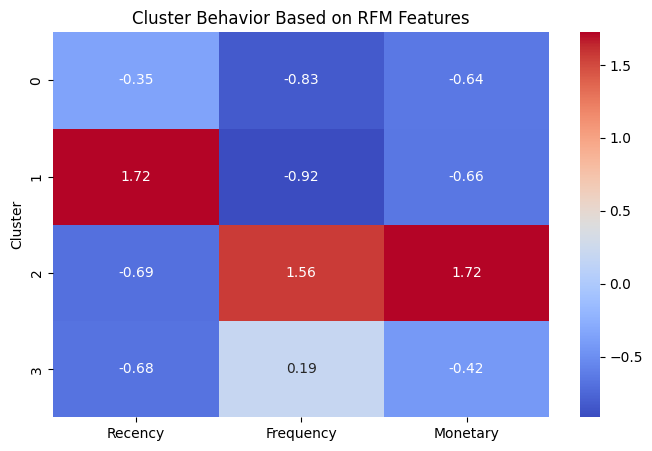

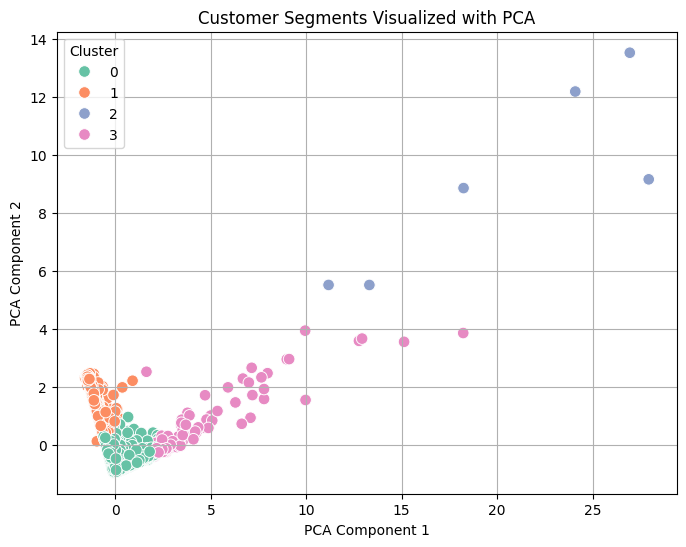

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("9. Customer Segmentation in E-commerce.csv")

# ✅ Fix 1: Convert InvoiceDate with explicit format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%y %H:%M")

# ✅ Fix 2: Drop missing CustomerID and copy to avoid SettingWithCopyWarning
df = df.dropna(subset=['CustomerID']).copy()

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Snapshot date for Recency calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Normalize the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans Clustering (k = 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster Summary
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize for heatmap
cluster_scaled = StandardScaler().fit_transform(cluster_summary)
cluster_df = pd.DataFrame(cluster_scaled,
                          index=cluster_summary.index,
                          columns=cluster_summary.columns)

# 🔥 Heatmap of cluster behavior
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cluster Behavior Based on RFM Features')
plt.show()

# 🧬 PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add PCA results to RFM table
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# 📊 Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=70)
plt.title('Customer Segments Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



